# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

--------------------------------------------

# Другой подход к кластеризации

Пробуем новую идею, если не получается кластеризовать все обьекты, будем делать так: мы же уже знаем какие есть кластеры, просто раздадим метки по ключевым словам, олценим сколько осталось и проведем еще одну кластеризацию. 

In [5]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search_full/*.parquet')).collect()
product_information = pl.read_csv(
    os.path.join(data_path, 'cluster_product_information_full.csv'),
    ignore_errors=True
)

val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

val_target.group_by('target').agg(pl.count('user_id'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


target,user_id
i32,u32
0,1227381
1,647575


In [6]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 4))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для последующего создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с указанием суффиксов
combined = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined = combined.join(
        agg, 
        on='user_id', 
        how='left',
        suffix=f"_{i}"  # Добавляем уникальный суффикс для каждого соединения
    )

In [7]:
# search_aggs
id_ = 4
suf = 'search'

# Сначала вычислим value_counts отдельно и развернем их в плоскую структуру
cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров (мера разнообразия)
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров (процент повторяющихся)
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_70324\276488151.py:52: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [8]:
product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [9]:
train_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < val_start_date) &  # до валидации
        (pl.col('timestamp').dt.date() >= val_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общая активность
        pl.count().alias('total_actions_30d'),
        
        # Разбивка по типам действий
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        # Финансовые метрики
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        # Временные характеристики (исправлено!)
        (val_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        # Метрики кластеров
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        # Производные признаки
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_70324\1964511306.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_actions_30d'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_70324\1964511306.py:31: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')


In [10]:
df_main = val_target
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )

df_main = df_main.join(product_cluster_aggs, on='user_id', how='left')
df_main = df_main.join(train_last_month_features, on='user_id', how='left')
    
df_pd = df_main.to_pandas()

columns_to_log = ['max_discount_price_click', 'num_products_favorite', 'sum_discount_price_favorite', 'max_discount_price_favorite',  'num_products_order', 'sum_discount_price_order', 'sum_discount_price_order',  'num_products_to_cart', 'max_discount_price_to_cart', 'num_search', 'unique_search_queries', 'num_search_last_month', 'num_search_last_week', 'search_daily_rate', 'search_cluster_switches', 'search_mean_query_len', 'search_main_cluster_query_len_diff']

df_pd = apply_log_transform(df_pd, columns_to_log, drop_original=True)

In [11]:
#pca
from local_utils import *

pca_cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})
df_pd = add_pca_columns(df_pd,  pca_cols,  n_components = 2)

Nans filled


In [12]:
#knn
knn_cols = ['days_since_first_order', 'days_since_last_order', 'sum_discount_price_to_cart', 'num_products_click', 'main_search_cluster', 'search_cluster_stability', 'product_cluster_stability']

df_pd = add_knn_features_faiss(df_pd, knn_cols, n_neighbors=5, use_gpu=True)

Nans filled
Data scaled
Using CPU
FAISS index built
KNN search done


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


KNN features created


------------------------------------------------------------

------------------------------------------------------------

------------------------------------------------------------

------------------------------------------------------------

------------------------------------------------------------

------------------------------------------------------------

In [13]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= val_end_date)
        .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с суффиксами
combined_val = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined_val = combined_val.join(
        agg, 
        on='user_id', 
        how='outer',
        suffix=f"_{i}"
    )

C:\Users\Admin\AppData\Local\Temp\ipykernel_70324\2116881979.py:59: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  combined_val = combined_val.join(


In [14]:
id_ = 4
suf = 'search'

# Вычисляем top3 кластеров для валидации (аналогично трейну)
val_cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(val_cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_70324\555555092.py:51: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [15]:
val_product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [16]:
test_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < test_start_date) &  # до теста
        (pl.col('timestamp').dt.date() >= test_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Те же метрики, что и для трейна
        pl.count().alias('total_actions_30d'),
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        (test_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_70324\4126633476.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_actions_30d'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_70324\4126633476.py:26: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')


In [18]:
from local_utils import *

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

test_df_main = test_users_submission
for _, actions_aggs_df in actions_aggs.items():
    test_df_main = (
        test_df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
test_df_main = test_df_main.join(val_product_cluster_aggs, on='user_id', how='left')
test_df_main = test_df_main.join(test_last_month_features, on='user_id', how='left')

test_df_pd = test_df_main.to_pandas()

test_df_pd = apply_log_transform(test_df_pd, columns_to_log, drop_original=True)

In [19]:
test_df_pd = add_pca_columns(test_df_pd,  pca_cols,  n_components = 2)

Nans filled


In [20]:
test_df_pd = add_knn_features_faiss(test_df_pd, knn_cols, n_neighbors=5, use_gpu=True)

Nans filled
Data scaled
Using CPU
FAISS index built
KNN search done


c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:118: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\_methods.py:152: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


KNN features created


In [21]:
def add_time_pattern_features(df_pd, actions_history, product_info):
    # Конвертируем product_info в LazyFrame если нужно
    product_info_lazy = product_info.lazy() if isinstance(product_info, pl.DataFrame) else product_info
    
    time_aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .with_columns([
            ((pl.col('timestamp').dt.hour() >= 6) & (pl.col('timestamp').dt.hour() < 12)).alias('new_is_morning'),
            ((pl.col('timestamp').dt.hour() >= 12) & (pl.col('timestamp').dt.hour() < 18)).alias('new_is_day'),
            (pl.col('timestamp').dt.weekday() >= 5).alias('new_is_weekend'),
            (pl.col('timestamp').dt.hour()).alias('new_hour'),
            (pl.col('timestamp').dt.weekday()).alias('new_dow')
        ])
        .join(
            product_info_lazy.select(['product_id', 'discount_price']), 
            on='product_id',
            how='left'
        )
        .group_by('user_id')
        .agg(
            (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
            (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
            (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
            pl.col('new_hour').value_counts().struct.field('count').entropy().alias('new_hour_entropy'),
            (pl.col('new_dow').filter(pl.col('new_dow') < 5).count() / 
             (pl.col('new_dow').filter(pl.col('new_dow') >= 5).count() + 1e-6)).alias('new_weekday_weekend_ratio'),
            (pl.col('discount_price').filter(pl.col('new_is_morning')).sum() / 
            (pl.col('new_is_morning').sum() + 1e-6)).alias('new_morning_avg_spend')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(time_aggs, on='user_id', how='left')

In [22]:
def add_brand_category_features(df_pd, actions_history, product_info):
    product_info_lazy = product_info.lazy() if isinstance(product_info, pl.DataFrame) else product_info
    
    brand_aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .join(
            product_info_lazy.select(['product_id', 'brand', 'category_id', 'discount_price']),
            on='product_id',
            how='left'
        )
        .group_by('user_id')
        .agg(
            pl.col('brand').n_unique().alias('new_unique_brands'),
            (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
            pl.col('category_id').n_unique().alias('new_unique_categories'),
            pl.col('category_id').value_counts().struct.field('count').max().alias('new_favorite_category_count'),
            (pl.col('discount_price').filter(pl.col('category_id') == 
             pl.col('category_id').mode().first()).mean()).alias('new_main_category_avg_price')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(brand_aggs, on='user_id', how='left')

In [23]:
def add_search_features(df_pd, search_history):
    search_aggs = (
        search_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .with_columns([
            pl.col('search_query').str.split(' ').list.len().alias('new_query_word_count'),  # Исправлено здесь
            pl.col('search_query').str.contains(r'\d').alias('new_has_numbers')
        ])
        .group_by('user_id')
        .agg(
            pl.mean('new_query_word_count').alias('new_avg_query_length'),
            (pl.sum('new_has_numbers') / pl.count()).alias('new_numeric_query_ratio'),
            pl.col('search_query').filter(pl.col('search_query').str.len_chars() > 20).count().alias('new_long_queries_count')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(search_aggs, on='user_id', how='left')

In [24]:
# Загрузите данные заново (если нужно)
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet'))
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search_full/*.parquet'))
product_info = product_information

# Добавляем новые признаки
add_new_df_pd = add_time_pattern_features(df_pd, actions_history, product_info)
add_new_df_pd = add_brand_category_features(add_new_df_pd, actions_history, product_info) 
add_new_df_pd = add_search_features(add_new_df_pd, search_history)

add_new_df_pd

C:\Users\Admin\AppData\Local\Temp\ipykernel_70324\703708266.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_70324\703708266.py:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_70324\703708266.py:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_70324\600433880.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_70324\2438321060.py:12: Deprecat

,user_id,target,num_products_click,sum_discount_price_click,last_click_time,first_click_time,days_since_last_click,days_since_first_click,last_favorite_time,first_favorite_time,...,new_weekday_weekend_ratio,new_morning_avg_spend,new_unique_brands,new_favorite_brand_ratio,new_unique_categories,new_favorite_category_count,new_main_category_avg_price,new_avg_query_length,new_numeric_query_ratio,new_long_queries_count
0,10571865,1,0.042564,39743.0,2024-06-28 21:49:21,2024-03-02 08:29:26,2.0,120.0,NaT,NaT,...,1.584337e+00,250.058631,76.0,0.195804,74.0,32.0,9.000000,2.786458,0.250000,72.0
1,9117270,1,0.014726,47627.0,2024-06-17 11:38:59,2024-03-06 19:02:12,13.0,116.0,NaT,NaT,...,4.408602e-01,880.036348,63.0,0.067164,61.0,10.0,441.800000,1.753086,0.024691,4.0
2,10474996,0,-0.008622,470.0,2024-05-26 16:15:02,2024-05-26 16:15:02,35.0,35.0,2024-06-09 20:29:17,2024-05-26 16:15:06,...,0.000000e+00,0.000000,3.0,0.500000,3.0,2.0,470.000000,1.500000,0.000000,0.0
3,748091,0,-0.009071,NaN,NaT,NaT,NaN,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1879454,1,0.034931,24185.0,2024-06-27 16:44:38,2024-03-04 11:13:03,3.0,118.0,NaT,NaT,...,1.251968e+00,252.158534,48.0,0.206294,59.0,29.0,98.034483,3.227273,0.136364,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1874951,1037626,0,0.007542,17284.0,2024-06-27 03:51:12,2024-03-28 23:10:36,3.0,94.0,2024-06-11 15:45:34,2024-03-28 23:18:24,...,5.461538e+00,347.416638,32.0,0.250000,24.0,26.0,707.769231,2.050000,0.275000,6.0
1874952,7331431,1,0.070851,123140.0,2024-06-28 17:19:10,2024-03-03 10:55:29,2.0,119.0,NaT,NaT,...,1.608000e+00,685.831927,78.0,0.113497,74.0,19.0,376.842105,1.866359,0.023041,24.0
1874953,5701572,0,-0.009071,NaN,NaT,NaT,NaN,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1874954,10412574,0,-0.009071,NaN,NaT,NaT,NaN,NaN,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Добавляем новые признаки
add_new_test_df_pd = add_time_pattern_features(test_df_pd, actions_history, product_info)
add_new_test_df_pd = add_brand_category_features(add_new_test_df_pd, actions_history, product_info) 
add_new_test_df_pd = add_search_features(add_new_test_df_pd, search_history)

add_new_test_df_pd

C:\Users\Admin\AppData\Local\Temp\ipykernel_70324\703708266.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_70324\703708266.py:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_70324\703708266.py:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_70324\600433880.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_70324\2438321060.py:12: Deprecat

,user_id,num_products_click,sum_discount_price_click,last_click_time,first_click_time,days_since_last_click,days_since_first_click,last_favorite_time,first_favorite_time,days_since_last_favorite,...,new_weekday_weekend_ratio,new_morning_avg_spend,new_unique_brands,new_favorite_brand_ratio,new_unique_categories,new_favorite_category_count,new_main_category_avg_price,new_avg_query_length,new_numeric_query_ratio,new_long_queries_count
0,1342,-0.008982,1213.0,2024-04-21 15:03:11,2024-04-21 15:03:11,101.0,101.0,2024-04-21 15:06:25,2024-04-21 15:06:25,101.0,...,0.000000e+00,77.999922,2.0,0.666667,2.0,2.0,1213.000000,NaN,NaN,NaN
1,9852,0.004668,14359.0,2024-07-11 06:51:15,2024-03-03 10:24:47,20.0,150.0,NaT,NaT,NaN,...,6.846154e-01,276.122949,54.0,0.095890,55.0,20.0,140.250000,NaN,NaN,NaN
2,10206,-0.009361,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,0.00,0.0
3,11317,-0.009361,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.000000,0.00,1.0
4,13289,-0.009361,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,0.00,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2068419,11157283,-0.009361,NaN,NaT,NaT,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2068420,11160395,-0.009361,NaN,NaT,NaT,NaN,NaN,2024-04-16 18:42:57,2024-04-16 18:42:57,106.0,...,9.999990e-01,0.000000,2.0,0.500000,2.0,1.0,48.000000,NaN,NaN,NaN
2068421,11165052,-0.005949,2515.0,2024-07-25 22:37:15,2024-04-04 01:23:31,6.0,118.0,NaT,NaT,NaN,...,1.571428e+00,104.692300,9.0,0.277778,11.0,5.0,70.000000,2.350000,0.05,3.0
2068422,11168218,-0.007844,870.0,2024-06-27 18:48:23,2024-04-04 06:00:33,34.0,118.0,NaT,NaT,NaN,...,2.000000e+07,193.749976,4.0,0.450000,4.0,9.0,109.666667,1.857143,0.00,0.0


NaN in train target: 0


In [42]:
import optuna
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import numpy as np
from local_utils import *

add_new_df_pd = add_new_df_pd[add_new_df_pd['user_id'] != 2346229]

lgb_tr, lgb_val = get_split(add_new_df_pd, val_size=0.25, random_state=50)

add_new_cols = list(set(add_new_df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                  'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                  'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})


def objective(trial, X_tr, y_tr, X_val, y_val):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'random_state': 42,
        
        # Параметры для оптимизации
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 75),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 10),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 10),
    }
    
    model = lgb.LGBMClassifier(
        n_estimators=1000,
        verbosity=-1,  # Управление выводом здесь
        **params
    )
    
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[
            lgb.early_stopping(stopping_rounds=60, verbose=False),
            lgb.log_evaluation(period=100)
        ]
        # Убрали параметр verbose
    )
    
    val_pred = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, val_pred)
    
    return auc

# Подготовка данных
X_tr = lgb_tr[add_new_cols]
y_tr = lgb_tr['target']
X_val = lgb_val[add_new_cols]
y_val = lgb_val['target']

# Проверка на NaN
assert not y_tr.isna().any(), "Train target contains NaN"
assert not y_val.isna().any(), "Validation target contains NaN"

# Оптимизация
study = optuna.create_study(direction='maximize')
study.optimize(
    lambda trial: objective(trial, X_tr, y_tr, X_val, y_val),
    n_trials=50,
    timeout=600,  # 1 час
    show_progress_bar=True
)

# Лучшие параметры
print("Best trial:")
trial = study.best_trial
print(f"  AUC: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Обучение финальной модели с лучшими параметрами
best_params = {
    'objective': 'binary',
    'metric': 'auc',
    'random_state': 42,
    'verbosity': 1,  # Управление выводом здесь
    'n_estimators': 2000,
    **study.best_params
}

final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(
    pd.concat([X_tr, X_val]),
    pd.concat([y_tr, y_val]),
    eval_set=[(X_val, y_val)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=60),
        lgb.log_evaluation(period=50)
    ]
)

[I 2025-04-06 20:41:45,049] A new study created in memory with name: no-name-1802eef5-d41b-4ca7-ba0c-d1db0c9caf0b


  0%|          | 0/50 [00:00<?, ?it/s]

[100]	valid_0's auc: 0.759309
[200]	valid_0's auc: 0.759977
[300]	valid_0's auc: 0.760233
[400]	valid_0's auc: 0.760392
[I 2025-04-06 20:42:36,674] Trial 0 finished with value: 0.7604337050677441 and parameters: {'learning_rate': 0.06751480336429398, 'num_leaves': 32, 'max_depth': 53, 'min_data_in_leaf': 89, 'feature_fraction': 0.8967419344212277, 'bagging_fraction': 0.6570200946900129, 'bagging_freq': 6, 'lambda_l1': 9.873028858190022, 'lambda_l2': 7.884755909469948}. Best is trial 0 with value: 0.7604337050677441.
[100]	valid_0's auc: 0.753997
[200]	valid_0's auc: 0.755004
[300]	valid_0's auc: 0.755646
[400]	valid_0's auc: 0.756046
[500]	valid_0's auc: 0.756343
[600]	valid_0's auc: 0.75668
[700]	valid_0's auc: 0.75696
[800]	valid_0's auc: 0.757133
[900]	valid_0's auc: 0.757387
[1000]	valid_0's auc: 0.757628
[I 2025-04-06 20:45:25,416] Trial 1 finished with value: 0.7576312394809468 and parameters: {'learning_rate': 0.003101237045865615, 'num_leaves': 32, 'max_depth': 59, 'min_data_in

LGBMClassifier(bagging_fraction=0.6570200946900129, bagging_freq=6,
               feature_fraction=0.8967419344212277, lambda_l1=9.873028858190022,
               lambda_l2=7.884755909469948, learning_rate=0.06751480336429398,
               max_depth=53, metric='auc', min_data_in_leaf=89,
               n_estimators=2000, num_leaves=32, objective='binary',
               random_state=42, verbosity=1)

feature_importance: [ 164  778  359  366  162  292  448  738  116  463  259  771  459  684
  775  186 1095  346  146  314  217  967  459  216  485   28  189  973
   35  500 1281  450  680  276  962   40    0  190   53  392  274  175
  267  362  707  291  361  806  242  956  493  231  928  176  912  290
 1011  439  515   69  849 1120 1098   70  777  191  543  525  199  484
  400   23  526  101  377  821   87  309 1115  743  124  316  336  243
  474 1001  124 1322  287  471   48  213  784  341   55  187  481  216
  358   57   92  156  721   83  144  363 1222  494 1099  242  272  231
   11    9 1018  441  925  121  539  409  162  177  244  449  662  131
  146  570 1022  404  365  830  215  685  985    2 1034  679] 



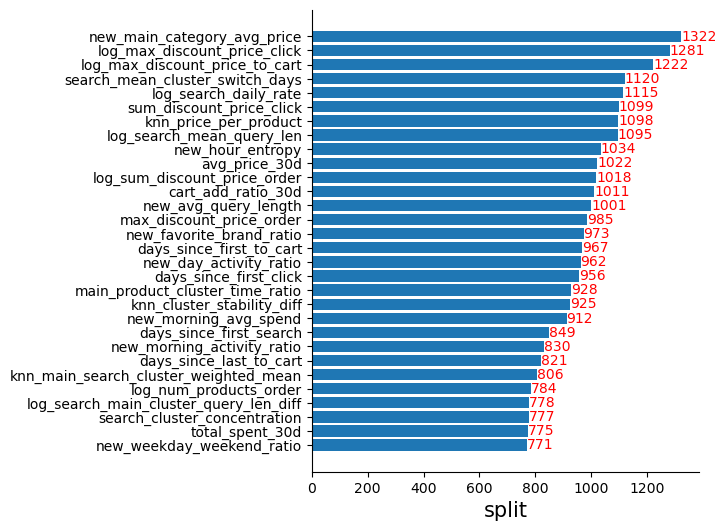

In [43]:
from local_utils import *

print('feature_importance:', final_model.feature_importances_, '\n')

plot_lgbm_importance(final_model, add_new_cols, importance_type='split', top_k=30, sklearn_style=True)

#res = list_lgbm_importance(lgb_model, cols, sklearn_style=True, top_k=30)

In [53]:
from local_utils import *

add_new_df_pd = add_new_df_pd[add_new_df_pd['user_id'] != 2346229]

tr, val = get_split(add_new_df_pd, val_size=0.25)

cols = list(set(add_new_df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                  'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                  'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

params={
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'max_depth': 100,
        'num_iterations': 700,
        'early_stopping_rounds': 60,
        'verbose': 1,
        'importance_type': 'split'
    }

model = train_model_new(tr, val, cols, 'target', params=params, shadow_features=False, sklearn_style=True)

[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] Number of positive: 484867, number of negative: 921349
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.307316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28234
[LightGBM] [Info] Number of data points in the train set: 1406216, number of used features: 138
[LightGBM] [Warning] early_stopping_round is set=60, early_stopping_rounds=60 will be ignored. Current value: early_stopping_round=60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.344803 -> initscore=-0.641964
[LightGBM] [Info] Start training from score -0.641964
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 60 rounds
[100]	train's auc: 0.757192	valid's auc: 0.758018
[200]	train's auc: 0.758408	valid's auc: 0.759024
[300]	tra

feature_importance: [   2   10   59  616  194   36   12  150    3  213   82  101    9   91
   95  168  344    8    4   45   73  422   29  102  825    2   97  168
    7  361  146   12  554  265   28    2    0   10    0   30  411   61
   18  269  217  101   18   52   49  154  407   34   51   17   42   74
  703    9  124   14  235   76  548   13   81   30   16   25   11  187
   16    0  438   11  117  299   25   37  367  162   11    6  378    7
    7  171   33  315   15  166    5    7 1091   12   25  223  349  329
   54   38    0  174  464    6   25  161  374  456  389   47  381   14
    0    0 1081   19  145    0   97  238  117   30  443   29   62    6
    9   58  107  332   74   89   20  123  577    0  678    9] 



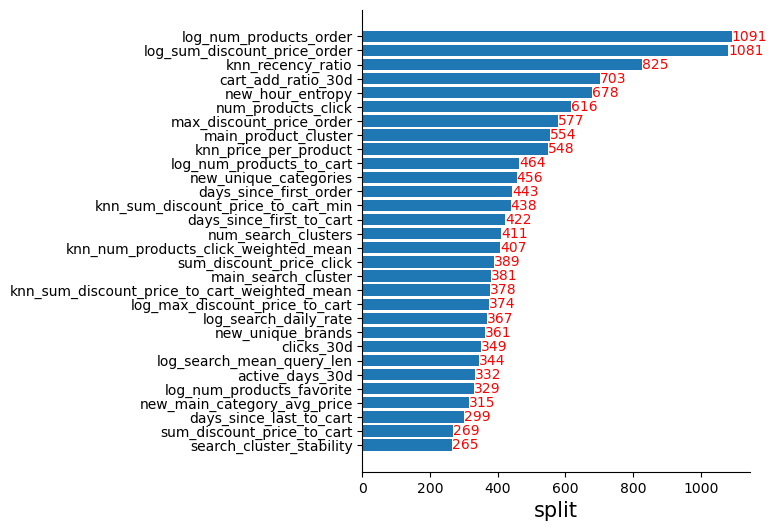

In [54]:
from local_utils import *

print('feature_importance:', model.feature_importances_, '\n')

plot_lgbm_importance(model, add_new_cols, importance_type='split', top_k=30, sklearn_style=True)

#res = list_lgbm_importance(lgb_model, cols, sklearn_style=True, top_k=30)

In [30]:
from local_utils import *

# Подготовка данных (аналогично вашему коду)
add_new_df_pd = add_new_df_pd[add_new_df_pd['user_id'] != 2346229]

tr, val = get_split(add_new_df_pd, val_size=0.25, random_state=45)

cols = list(set(add_new_df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

# Параметры CatBoost (аналогичные вашим LGBM параметрам)
params = {
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'learning_rate': 0.01,
    'depth': 10,  # Аналог max_depth в LGBM
    'iterations': 900,
    'early_stopping_rounds': 60,
    'verbose': 1,
    'random_seed': 42,
    'thread_count': -1,  # Использовать все ядра
    'grow_policy': 'Lossguide', # Более быстрый режим роста
}

catboost_model = train_catboost_model(tr, val, cols, 'target', params=params, shadow_features=False, sklearn_style=True)

0:	test: 0.7400693	best: 0.7400693 (0)	total: 553ms	remaining: 8m 17s
100:	test: 0.7510710	best: 0.7510710 (100)	total: 42.8s	remaining: 5m 38s
200:	test: 0.7559903	best: 0.7559903 (200)	total: 1m 28s	remaining: 5m 8s
300:	test: 0.7576730	best: 0.7576730 (300)	total: 2m 16s	remaining: 4m 32s
400:	test: 0.7584729	best: 0.7584729 (400)	total: 3m 9s	remaining: 3m 56s
500:	test: 0.7589957	best: 0.7589957 (500)	total: 4m 4s	remaining: 3m 15s
600:	test: 0.7594876	best: 0.7594876 (600)	total: 5m 3s	remaining: 2m 31s
700:	test: 0.7598515	best: 0.7598566 (699)	total: 6m 3s	remaining: 1m 43s
800:	test: 0.7601049	best: 0.7601049 (800)	total: 7m 5s	remaining: 52.6s
899:	test: 0.7603497	best: 0.7603497 (899)	total: 8m 8s	remaining: 0us

bestTest = 0.7603497187
bestIteration = 899



feature_importance: [7.15257284e-03 4.33115666e-02 2.08935294e+00 2.99374629e-01
 2.19612478e-01 1.10406752e-01 4.93959578e-03 5.21268886e-02
 9.86617037e-02 1.90412284e-01 2.04123697e-01 2.63569332e-02
 1.35271069e-02 4.03377216e-02 2.76426327e-02 4.52622720e-01
 1.92599653e-01 2.00796166e-02 6.66434441e-02 1.32256381e-01
 6.41966670e-02 3.53385969e-01 4.79072006e-02 8.43326425e-02
 6.40757487e+00 4.61203683e-04 2.79040076e-01 2.17593865e-02
 6.85848767e-03 1.27868365e-01 5.67591170e-02 3.15086994e-02
 1.19494482e-01 1.25487450e-01 6.85089201e-03 1.39004993e-02
 4.77009142e-05 2.72849886e-02 9.52705405e-03 1.17987967e-01
 3.89595033e-01 4.93654680e-02 8.14933601e-03 1.02383308e+00
 7.08953216e-02 1.93407908e-01 1.29578923e-02 1.89670814e-02
 1.13696444e+00 5.95933491e-02 1.33564974e-01 5.50397514e-02
 9.91496781e-03 4.72899075e-02 1.89747920e-02 4.14442239e-01
 2.04917520e-01 1.62263358e-01 2.67535183e-02 1.72616820e-01
 2.31474542e-01 7.50784251e-02 3.48963049e-01 3.33211972e-01
 3.3

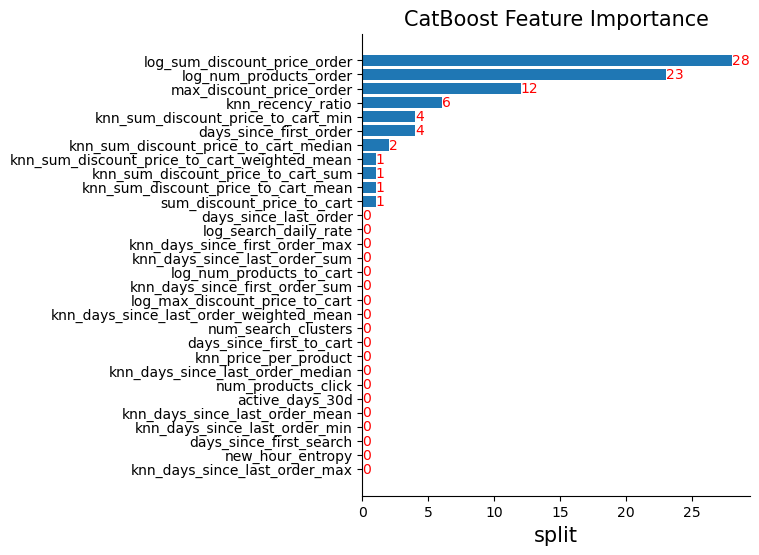

In [31]:
from local_utils import *

print('feature_importance:', catboost_model.feature_importances_, '\n')

plot_catboost_importance(catboost_model, cols, importance_type='split', top_k=30, sklearn_style=True)

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

In [55]:
add_new_test_df_pd['catboost_predict'] = catboost_model.predict_proba(add_new_test_df_pd[cols])[:, 1]
add_new_test_df_pd['lgb_predict'] = model.predict_proba(add_new_test_df_pd[cols])[:, 1]

In [48]:
add_new_test_df_pd['predict'] = final_model.predict_proba(add_new_test_df_pd[cols])[:, 1]

[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] feature_fraction is set=0.8967419344212277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8967419344212277
[LightGBM] [Warning] lambda_l1 is set=9.873028858190022, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.873028858190022
[LightGBM] [Warning] lambda_l2 is set=7.884755909469948, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.884755909469948
[LightGBM] [Warning] bagging_fraction is set=0.6570200946900129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6570200946900129
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


In [56]:
add_new_test_df_pd['predict'] = add_new_test_df_pd[['catboost_predict', 'lgb_predict']].mean(axis=1)

In [57]:
add_new_test_df_pd[['user_id', 'catboost_predict', 'lgb_predict', 'predict']]

,user_id,catboost_predict,lgb_predict,predict
0,1342,0.181566,0.173783,0.177675
1,9852,0.743954,0.758067,0.751010
2,10206,0.245144,0.240299,0.242722
3,11317,0.231209,0.213159,0.222184
4,13289,0.607238,0.590823,0.599031
...,...,...,...,...
2068419,11157283,0.217479,0.200037,0.208758
2068420,11160395,0.180005,0.146585,0.163295
2068421,11165052,0.597076,0.616003,0.606540
2068422,11168218,0.573753,0.555218,0.564485


In [58]:
add_new_test_df_pd[['user_id', 'predict']].to_csv('00000.csv', index=False)

In [ ]:
test_df_pd['catboost_predict'] = catboost_model.predict_proba(test_df_pd[cols])[:, 1]
test_df_pd['lgb_predict'] = lgb_model.predict_proba(test_df_pd[cols])[:, 1]

#test_df_pd['predict'] = model.predict(test_df_pd[cols])

In [ ]:
test_df_pd['predict'] = test_df_pd[['catboost_predict', 'lgb_predict']].mean(axis=1)

In [ ]:
test_df_pd[['user_id', 'catboost_predict', 'lgb_predict', 'predict']]

,user_id,catboost_predict,lgb_predict,predict
0,1342,0.160576,0.172984,0.166780
1,9852,0.750933,0.808319,0.779626
2,10206,0.214917,0.221423,0.218170
3,11317,0.214947,0.228265,0.221606
4,13289,0.604772,0.598704,0.601738
...,...,...,...,...
2068419,11157283,0.197924,0.200426,0.199175
2068420,11160395,0.163636,0.144137,0.153886
2068421,11165052,0.613123,0.631671,0.622397
2068422,11168218,0.555000,0.526293,0.540646


In [ ]:
test_df_pd[['user_id', 'predict']].to_csv('full_ensemble_cat_and_lgb_mean.csv', index=False)